### А/А тест с бутстрапом

Нужно сделать следующее:

1. Берём данные АА-теста из следующего диапазона: с '2025-02-14' по '2025-02-20'
2. Из групп 2 и 3 берём подвыборки без возвращения размером в 500 юзеров
3. Сравниваем их t-тестом и сохраняем p-value (здесь и далее используем аргумент equal_var=False)
4. Повторяем это 10000 раз


Нарисовать гистограмму получившихся p-value и посчитайте долю p-value, оказавшихся ниже порога значимости в 0.05. Что мы можем сказать по этому результату?


In [1]:
import pandahouse

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250320'
}

q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-02-14' and '2025-02-20'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

group_A = df[df.exp_group == 2].copy()
group_B = df[df.exp_group == 3].copy()


In [3]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727
...,...,...,...,...,...
16782,3,122008,20,123,0.162602
16783,2,25383,2,18,0.111111
16784,3,122190,15,56,0.267857
16785,2,108927,16,51,0.313725


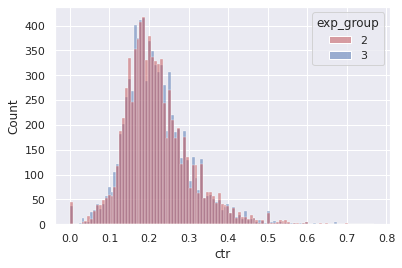

In [12]:
import seaborn as sns

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [15]:
from scipy import stats
p = []
for i in range(10000):
    _, p_value = stats.ttest_ind(group_A.ctr.sample(n=500, replace=False),
                                 group_B.ctr.sample(n=500, replace=False),
                                 equal_var=False)
    p.append(p_value)

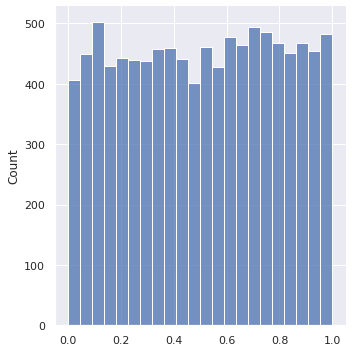

In [17]:
sns.displot(p)

In [19]:
import numpy as np
sum(np.array(p) < 0.05)/10000

0.0455

**Вывод:** Распределение получившихся p-value является примерно равномерным. Доля p-value ниже порога значимости составляет около 0.046. Это примерно столько, сколько мы ожидаем. Значит, система сплитования работает корректно.